In [2]:
import os, sys
import glob
import datetime as dt
import numpy as np
import xarray as xr

import time 

In [79]:
forecast_path = "/p/home/jusers/langguth1/juwels/video_prediction_shared_folder/results/era5-Y2007-2019M01to12-80x48-3960N0180E-2t_tcc_t_850_langguth1/savp/20210505T131220_mache1_karim_savp_smreg_cv3_3"
fnames= os.path.join(forecast_path, "vfp_date_*sample_ind_*.nc" )

fnames = glob.glob(fnames)
print(len(fnames))

dfile = xr.open_dataset(fnames[99])

print(dfile.data_vars)
#print(dfile["init_time"])
#print(dfile["2t_savp_fcst"][2])

8440
Data variables:
    2t_in                   (in_hour, lat, lon) float32 ...
    tcc_in                  (in_hour, lat, lon) float32 ...
    t_850_in                (in_hour, lat, lon) float32 ...
    2t_ref                  (fcst_hour, lat, lon) float32 ...
    tcc_ref                 (fcst_hour, lat, lon) float32 ...
    t_850_ref               (fcst_hour, lat, lon) float32 ...
    2t_savp_fcst            (fcst_hour, lat, lon) float32 ...
    tcc_savp_fcst           (fcst_hour, lat, lon) float32 ...
    t_850_savp_fcst         (fcst_hour, lat, lon) float32 ...
    2t_persistence_fcst     (fcst_hour, lat, lon) float64 ...
    tcc_persistence_fcst    (fcst_hour, lat, lon) float64 ...
    t_850_persistence_fcst  (fcst_hour, lat, lon) float64 ...


In [80]:
def non_interst_vars(ds):
    """
    Creates list of variables that are not of interest. For this, vars2proc must be defined at global scope
    :param ds: the dataset
    :return: list of variables in dataset that are not of interest
    """
    return [v for v in ds.data_vars
            if v not in vars2proc]
#
# ====================================================================================================


def get_relevant_vars(ds):
    """
    Drops variables that are not of interest from dataset and also shrinks data to cells of interest.
    For this, ncells must be a dimension of the dataset and dmask_ref_inds must be defined at gloabl scope
    :param ds: the dataset
    :return: dataset with non-interesting variables dropped and data shrinked to region of interest
    """
    return ds.drop(non_interst_vars(ds)).isel(fcst_hour=11)

In [81]:
vars2proc = ["2t_savp_fcst", "2t_ref"]

time0 = time.time()
with xr.open_mfdataset(fnames, decode_cf=True, combine="nested", concat_dim=["init_time"], compat="broadcast_equals", preprocess=get_relevant_vars) as dfiles:
    data = dfiles.load()
    #times0 = dfiles["time_forecast"]
    print("Registering and loading data took {0:.2f} seconds".format(time.time()- time0))

Registering and loading data took 1057.31 seconds


In [82]:
data_correct = xr.Dataset({"2t_savp_fcst": data["2t_savp_fcst"], "2t_ref": data["2t_ref"]})
print(data_correct)

<xarray.Dataset>
Dimensions:       (init_time: 8440, lat: 48, lon: 80)
Coordinates:
  * init_time     (init_time) datetime64[ns] 2010-08-20T05:00:00 ... 2010-03-...
  * lat           (lat) float64 53.7 53.4 53.1 52.8 52.5 ... 40.5 40.2 39.9 39.6
  * lon           (lon) float64 1.8 2.1 2.4 2.7 3.0 ... 24.3 24.6 24.9 25.2 25.5
    fcst_hour     int64 12
Data variables:
    2t_savp_fcst  (init_time, lat, lon) float32 291.3 291.8 ... 288.5 288.2
    2t_ref        (init_time, lat, lon) float32 292.2 292.1 ... 288.5 288.6


In [83]:
data_fcst, data_ref = data_correct["2t_savp_fcst"], data_correct["2t_ref"]

fcst_min, fcst_max = np.floor(np.min(data_fcst)), np.ceil(np.max(data_fcst))
x_bins = list(np.arange(int(fcst_min), int(fcst_max) + 1))
x_bins_c = 0.5*(np.asarray(x_bins[0:-1]) + np.asarray(x_bins[1:]))
nbins = len(x_bins) - 1

print(x_bins)

[242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313]


In [84]:
import matplotlib.pyplot as plt

quantiles = [0.05, 0.5, 0.95]
nquantiles = len(quantiles)
quantile_panel = xr.DataArray(np.full((nbins, nquantiles), np.nan), coords={"bin_center": x_bins_c, "quantile": quantiles},
                              dims=["bin_center", "quantile"])
for i in np.arange(nbins):
    data_cropped = data_correct["2t_ref"].where(np.logical_and(data_correct["2t_savp_fcst"] >= x_bins[i],
                                                               data_correct["2t_savp_fcst"] < x_bins[i+1]))
    quantile_panel.loc[dict(bin_center=x_bins_c[i])] = data_cropped.quantile([0.05, 0.5, 0.95])
    
x_bins_c = x_bins_c - 273.15
quantile_panel = quantile_panel - 273.15

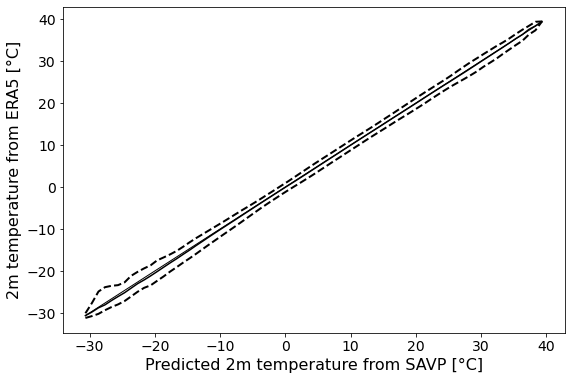

In [85]:
fig, ax = plt.subplots(figsize=(9,6))

ls_all = ["--", "-", "--"]
lw_all = [2., 1.5, 2.]
ax.plot(x_bins_c, x_bins_c, color='k', label='reference 1:1', linewidth=1.)
for i in np.arange(3):
    ax.plot(x_bins_c, quantile_panel.isel(quantile=i), ls=ls_all[i], color="k", lw=lw_all[i])
    
ax.set_ylabel("2m temperature from ERA5 [°C]", fontsize=16)
ax.set_xlabel("Predicted 2m temperature from SAVP [°C]", fontsize=16)

ax.tick_params(axis="both", labelsize=14)

fig.savefig("./first_cond_quantile.png")
    

In [7]:
#data_grouped = data_correct.groupby_bins("2t_savp_fcst", x_bins)#.groups

In [148]:
inds_of_bins = np.digitize(data_fcst, x_bins, right=True)

print(inds_of_bins)

[[[22 22 22 ... 18 18 18]
  [22 22 22 ... 18 18 18]
  [22 22 22 ... 19 19 19]
  ...
  [29 29 29 ... 30 30 30]
  [29 30 29 ... 31 31 31]
  [29 30 29 ... 31 31 31]]

 [[21 21 21 ... 20 20 20]
  [20 21 21 ... 20 20 20]
  [20 21 21 ... 20 20 20]
  ...
  [30 30 30 ... 31 31 31]
  [30 30 30 ... 31 31 31]
  [30 30 30 ... 31 31 31]]

 [[21 21 21 ... 21 21 21]
  [21 21 21 ... 21 21 21]
  [21 21 21 ... 21 21 21]
  ...
  [28 28 28 ... 31 31 31]
  [28 28 28 ... 32 32 31]
  [28 29 29 ... 32 32 32]]

 ...

 [[22 22 22 ... 20 20 20]
  [22 22 22 ... 20 20 20]
  [22 21 21 ... 20 20 20]
  ...
  [29 29 29 ... 31 31 31]
  [29 29 29 ... 32 32 32]
  [30 30 29 ... 32 32 32]]

 [[21 21 21 ... 20 20 20]
  [20 21 21 ... 20 20 20]
  [20 20 21 ... 20 20 20]
  ...
  [30 30 30 ... 31 31 31]
  [30 30 29 ... 31 31 31]
  [30 30 30 ... 31 31 31]]

 [[22 22 22 ... 24 24 24]
  [22 22 22 ... 24 23 24]
  [22 22 22 ... 24 24 24]
  ...
  [27 27 27 ... 31 31 31]
  [28 28 28 ... 32 32 32]
  [28 28 28 ... 32 32 32]]]


In [149]:
def calc_quantile(x, dim ="init_time"):
    return x.quantile(0.99)

cond_quantile1 = data_grouped.map(calc_quantile)
#cond_quantile2 = data_grouped.map(calc_quantile)


print(cond_quantile1["quantile"])
print(cond_quantile1["2t_savp_fcst"])

#print(cond_quantile2["2t_ref"])
#print(cond_quantile2["2t_savp_fcst"])

<xarray.DataArray '2t_ref' (2t_savp_fcst_bins: 37)>
array([259.60351562, 264.13945557, 264.74759033, 265.45030518,
       266.47970703, 267.3628302 , 268.44342804, 269.80157959,
       270.4291217 , 271.22656982, 272.41841827, 274.18320801,
       274.74815369, 275.68839111, 276.3840918 , 277.0491394 ,
       277.99171387, 279.1111615 , 280.24440918, 281.56947693,
       282.817146  , 284.15313873, 285.25139038, 286.46736084,
       287.11281006, 287.56309875, 288.39205322, 289.28383789,
       290.12092529, 291.00213623, 291.93958588, 292.7901001 ,
       294.50114746, 295.28106201, 295.7451416 , 296.17975464,
       295.94475342])
Coordinates:
  * 2t_savp_fcst_bins  (2t_savp_fcst_bins) object (260, 261] ... (296, 297]
    quantile           float64 0.99
<xarray.DataArray '2t_savp_fcst' (2t_savp_fcst_bins: 37)>
array([260.51538086, 261.99571045, 262.96671509, 263.99466095,
       264.98212372, 265.99100769, 266.99321747, 267.99145386,
       268.99003754, 269.9897348 , 270.99363922, 2